### SEGMENT ANYTHING MODEL (META)

https://huggingface.co/facebook/sam-vit-base

**IMPORTS**

In [1]:
# system
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../..')))

from config.path import get_training_data_path, get_checkpoint_path, DATASET_PATH_TYPE
from src.utils.augmentation import erase_generator
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

import cv2
import supervision as sv

**INSTALLS**

In [2]:
# %pip install -q 'git+https://github.com/facebookresearch/segment-anything.git'
# %pip install -q jupyter_bbox_widget roboflow dataclasses-json supervision
# !wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth -P ./weights

In [3]:
CHECKPOINT_PATH = get_checkpoint_path("sam_vit_h_4b8939.pth")
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"

https://github.com/facebookresearch/segment-anything/blob/main/segment_anything/automatic_mask_generator.py

In [6]:
sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=5,
    pred_iou_thresh=0.9,
    stability_score_thresh=0.9,
    crop_n_layers=1,
    crop_n_points_downscale_factor=0.5,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

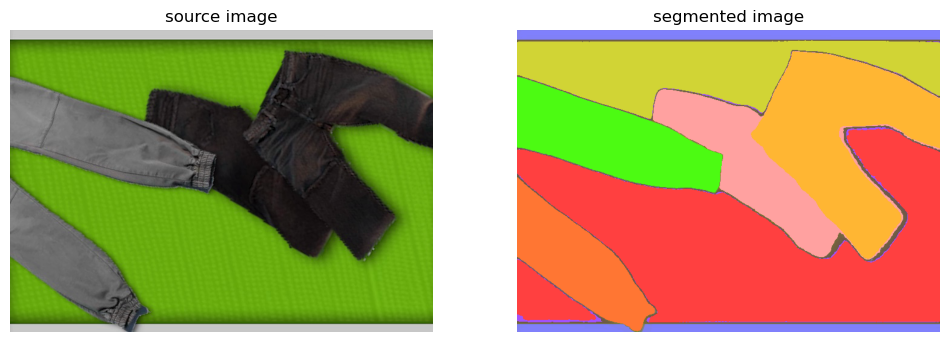

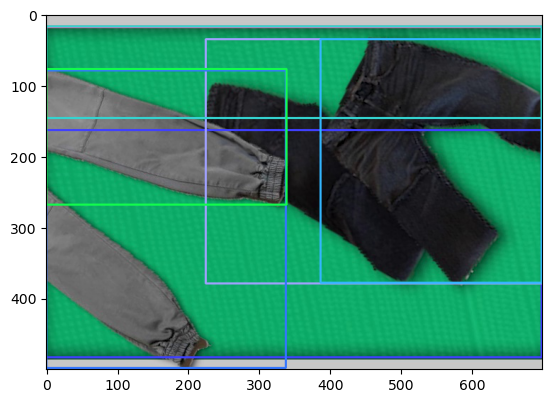

In [13]:
relative_path = get_training_data_path('production', 'band')

file_names = []

file_name = 'frame_304test.jpg'

# Iterate over files in the current directory
for i in range(0, 1, 20):
    fullpath = os.path.join(relative_path, file_name)

    orig_image = Image.open(fullpath)
    orig_image = orig_image.rotate(i)
    #image = erase_generator(path=fullpath)
    n_image = np.array(orig_image)
    #n_image = cv2.resize(n_image, (350, 250))
    gray_image = cv2.cvtColor(n_image, cv2.COLOR_BGR2GRAY)
    #blurred_image = cv2.equalizeHist(gray_image)
    # Convert image to YCrCb color space, then apply blurring and shadow removal
    image_ycrcb = cv2.cvtColor(n_image, cv2.COLOR_BGR2YUV)

    image_ycrcb[:,:,0] = cv2.equalizeHist(image_ycrcb[:,:,0])

    blurred_image = cv2.medianBlur(image_ycrcb, 1)
    #processed_image = remove_shadow_rgb(blurred_image)  # Assuming remove_shadow_rgb can handle YCrCb images

    # Generate masks and filter them
    masks = mask_generator.generate(blurred_image)
    cleaned_masks = [mask for mask in masks if mask['area'] > 30000]

    # Annotation of the image
    mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX, opacity=1.0)
    detections = sv.Detections.from_sam(sam_result=cleaned_masks)
    annotated_image = mask_annotator.annotate(scene=blurred_image.copy(), detections=detections)
    
    #Displaying images
    sv.plot_images_grid(
        images=[n_image, annotated_image],
        grid_size=(1, 2),
        titles=['source image', 'segmented image']
    )

    # Bounding box annotation on the original image for consistency
    bounding_box_annotator = sv.BoundingBoxAnnotator(color_lookup=sv.ColorLookup.INDEX)
    final_annotated_image = bounding_box_annotator.annotate(
        scene=n_image, detections=detections)

    plt.imshow(final_annotated_image)

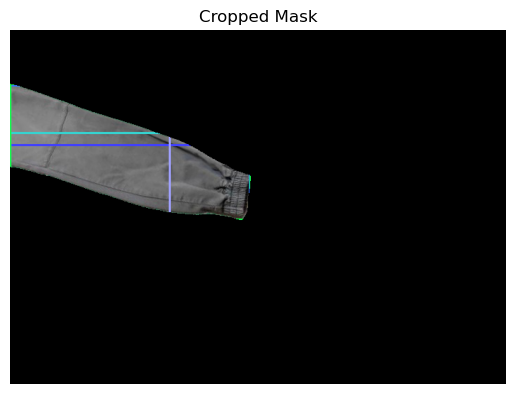

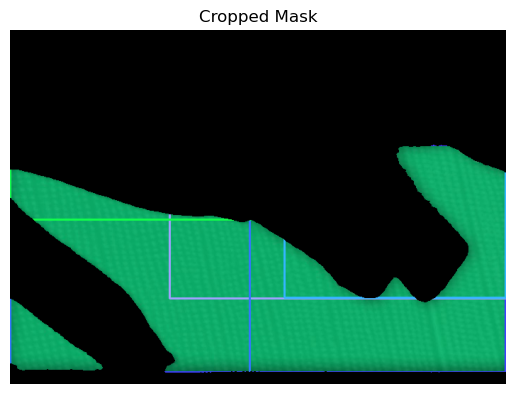

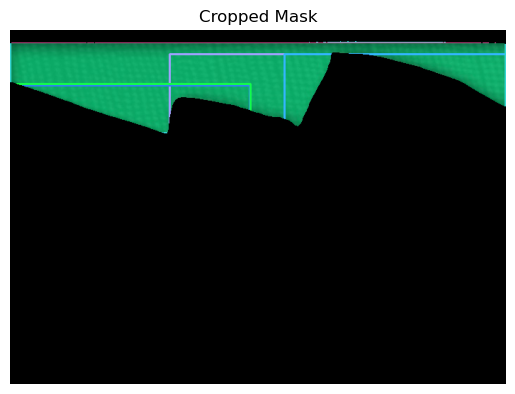

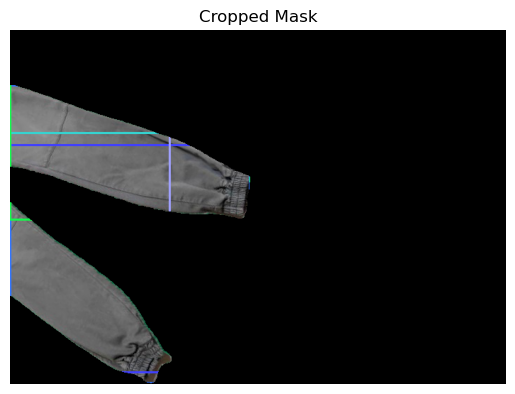

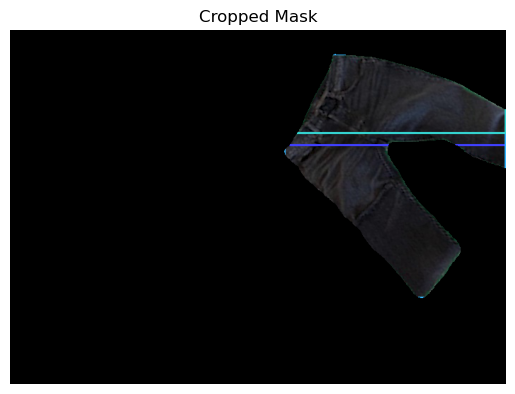

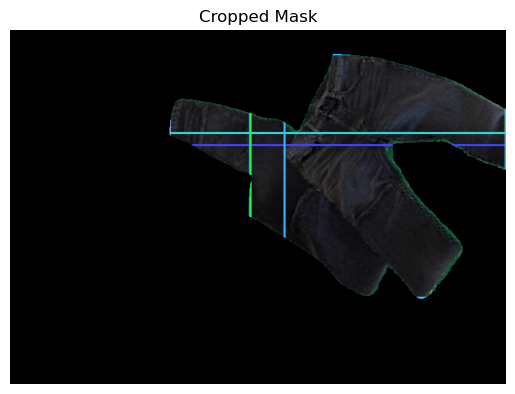

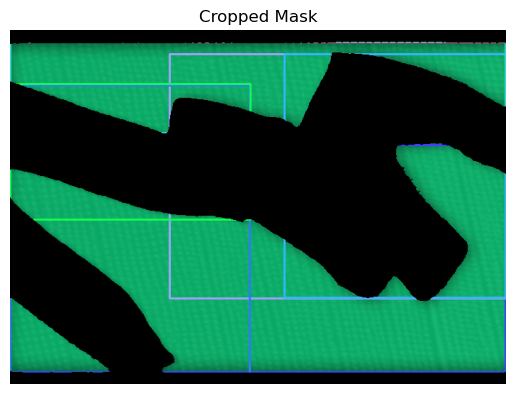

In [17]:
masks_cleaned = []
for mask in masks: 
    if np.mean(mask['segmentation'][3]) <= 0.2 and (mask['area'] >= 25000 and mask['area'] <= 100000):
        masks_cleaned.append(mask)

x, y, w, h = cleaned_masks[0]['bbox']


# Assuming cleaned_masks is your input list of masks
for mask in cleaned_masks:
    cropped_mask = mask['segmentation']
    cropped_mask = cropped_mask.astype(np.uint8) * 255
    masked_image = cv2.bitwise_and(n_image, n_image, mask=cropped_mask)
    plt.figure()  # Create a new figure for each mask
    plt.imshow(masked_image)
    plt.title('Cropped Mask')
    plt.axis('off')  # Hide axis
    plt.show()

# print(cropped_mask.shape)

# # cv2.imwrite('tshirt_base.png', cropped_mask)
# masked_image = cv2.bitwise_and(n_image, n_image, mask=cropped_mask)

# plt.imshow(masked_image)

# cv2.imwrite('image.png', masked_image)

In [ ]:
# masks_cleaned = []
# for mask in masks: 
#     if np.mean(mask['segmentation'][3]) <= 0.2 and (mask['area'] >= 25000 and mask['area'] <= 100000):
#         masks_cleaned.append(mask)

# masked_image = n_image
# x, y, w, h = cleaned_masks[1]['bbox']
# print(cleaned_masks[1]['area'])
# cv2.rectangle(masked_image, (x, y), (x + w, y + h), (0, 255,0), 3)
# cropped_image = masked_image[y:y+h, x:x+w]


# #plt.imshow(cropped_image)

# cropped_mask = cleaned_masks[1]['segmentation'][y:y+h, x:x+w]
# cropped_mask = cropped_mask.astype(np.uint8) * 255
# masked_image = cv2.bitwise_and(cropped_image, cropped_image, mask=cropped_mask)


# masked_image = cv2.resize(masked_image, (256, 256))
# plt.imshow(masked_image)

In [ ]:
blueprint_tshirt = cv2.imread('blueprints/tshirt_base.png', cv2.IMREAD_GRAYSCALE)
blueprint_shirt = cv2.imread('blueprints/jacket_shirt_base.png', cv2.IMREAD_GRAYSCALE)
blueprint_rect = cv2.imread('blueprints/rect_base.png', cv2.IMREAD_GRAYSCALE)
blueprint_elliptic = cv2.imread('blueprints/elliptic_base.png', cv2.IMREAD_GRAYSCALE)
# Threshold to create a binary mask
_, blueprint_mask_tshirt = cv2.threshold(blueprint_tshirt, 128, 255, cv2.THRESH_BINARY)
_, blueprint_mask_shirt = cv2.threshold(blueprint_shirt, 128, 255, cv2.THRESH_BINARY)
_, blueprint_mask_base = cv2.threshold(blueprint_rect, 128, 255, cv2.THRESH_BINARY)
_, blueprint_mask_elliptic = cv2.threshold(blueprint_elliptic, 128, 255, cv2.THRESH_BINARY)
blueprint_masks = [['large_rect', blueprint_mask_base]]

#cropped_mask = cv2.resize(cropped_mask, (256, 256))

plt.imshow(blueprint_mask_base)

In [ ]:
rotated_masks = []
angle_step = 10
for angle in range(0, 360, angle_step):
    (h, w) = cropped_mask.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(cropped_mask, M, (w, h), flags=cv2.INTER_NEAREST)
    rotated_masks.append(rotated)

In [ ]:
def compute_overlap(mask1, mask2):
    # Compute the overlapping area between two binary masks
    overlap = np.sum((mask1 == 255) & (mask2 == 255))
    return overlap

def find_best_rotation(input_mask, blueprint_mask, angle_step=1):
    best_angle = 0
    max_overlap = 0
    
    for angle in range(0, 360, angle_step):
        # Rotate the input mask
        rotated_mask = rotate_image(input_mask, angle)
        
        # Compute the overlap with the blueprint mask
        overlap = compute_overlap(rotated_mask, blueprint_mask[1])
        if overlap > max_overlap:
            max_overlap = overlap
            best_angle = angle
    
    #print(f"Best mask: {blueprint_mask[0]}")
    return [max_overlap, best_angle]

def rotate_image(image, angle):
    (h, w) = image.shape[:2]
    center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_NEAREST)
    return rotated



def plot_before_after_rotations(rotated_masks, original_image, num_rows=18):
    fig, axs = plt.subplots(num_rows, 4, figsize=(16, num_rows * 3))
    plt.subplots_adjust(hspace=0.0, wspace=0.0)  # Reduce padding between subplots

    for i in range(num_rows):
        line_ax = fig.add_subplot(num_rows, 1, i + 1, frame_on=False)
        line_ax.plot([0.5, 0.5], [0, 1], transform=fig.transFigure, color='red', linestyle='--')
        line_ax.axis('off')  # Turn off the axis

    for i, mask in enumerate(rotated_masks):
        # Find the best rotation angle
        tester = rotate_image(original_image, i * 10)
        angles = []
        for blueprint_mask in blueprint_masks:
            best_angle = find_best_rotation(mask, blueprint_mask)
            angles.append(best_angle)
        best_angle_final = np.max(angles, axis=0)[1]

        aligned_image = rotate_image(tester, best_angle_final)
        
        row = i // 2
        col = (i % 2) * 2
        
        axs[row, col].imshow(tester, cmap='gray')
        axs[row, col].set_title(f'Before Rotation {i*10}°')
        axs[row, col].axis('off')

        axs[row, col + 1].imshow(aligned_image, cmap='gray')
        axs[row, col + 1].set_title(f'After Best Rotation {best_angle_final}°')
        axs[row, col + 1].axis('off')

    plt.tight_layout()
    plt.savefig(f'./plots/{file_name}')


plot_before_after_rotations(rotated_masks, masked_image)

